In [1]:
import numpy as np
import pandas as pd
import os
# import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import direction_utils as utils
import direction_learning_utils as train_utils

torch.manual_seed(0)
torch.cuda.manual_seed(0) 
np.random.seed(0)

In [2]:
def model_using_calibration_data(verbose=False):
    torch.manual_seed(0)
    parent_dir = os.path.dirname(os.getcwd())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    batch_size=32
    fs = 500
    train_ratio = 0.9
    sub = 7 #Till subject 7 (starting from 0), only calibration sessions are conducted

    # Xtr, Ytr = create_dataset(sub, base_path=parent_dir)
    Xtr, Ytr = utils.calib_sess_dataset(base_path=parent_dir)
    # Creating train-validation split

    eeg_train, eeg_val, label_train, label_val = train_test_split(Xtr, Ytr, 
                                                                train_size=train_ratio, random_state=42, shuffle=True)
    
    train_loader = train_utils.convert_to_tensor(eeg_train, label_train)
    val_loader = train_utils.convert_to_tensor(eeg_val, label_val)

    

    # X_train = utils.baseline_correction(Xtr)
    # X_train = utils.bandpass_filtering(X_train)

    # X_train_tensor = torch.tensor(eeg_train, dtype=torch.float32).unsqueeze(1).permute(0, 1, 3, 2).to(device)  # Shape: (batch_size, 1, 27, 2500)
    # Y_train_tensor = torch.tensor(label_train, dtype=torch.long).to(device)  # Use long for classification

    # X_val_tensor = torch.tensor(eeg_val, dtype=torch.float32).unsqueeze(1).permute(0, 1, 3, 2).to(device)  # Shape: (batch_size, 1, 27, 2500)
    # Y_val_tensor = torch.tensor(label_val, dtype=torch.long).to(device)

    # train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    # test_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

    # train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


    model = train_utils.EEGNet(nb_classes=2, Chans=27, Samples=2000).to(device)
    # optimizer = optim.Adam(model.parameters(), lr=1e-3)
    trained_model = train_utils.model_training(model, train_loader, val_loader, verbose=verbose)
    # torch.save(trained_model.state_dict(), 'calibrated_EEGNetSEPerElectrode_model.pth')  # Save best model
    torch.save(trained_model.state_dict(), 'basedEEGNetSE_model.pth')

    return trained_model
    

In [3]:
def evaluation_on_online_data(model_file):
    torch.manual_seed(0)
    parent_dir = os.path.dirname(os.getcwd())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size=32

    model = train_utils.EEGNet(nb_classes=2, Chans=27, Samples=2000).to(device)
    model.load_state_dict(torch.load(f'{model_file}.pth'))

    # hook_handle = model.se_electrode1.sigmoid.register_forward_hook(forward_hook)


    online_perf = dict()
    el_ranks_at_layer1 = []
    el_ranks_at_layer2 = []
    filter_scales_se1 = []
    filter_scales_se2 = []
    filter_scales_se3 = []

    for sub in range(8, 21):
        Xtr, Ytr, Xte, Yte = utils.online_sess_dataset(sub, base_path=parent_dir)
        batch_size = Yte.size
        # print(batch_size)
        test_loader = train_utils.convert_to_tensor(Xte, Yte, batch_size=batch_size)

        test_loss, test_acc, assigned_ranks = train_utils.model_evaluation(model, test_loader)
        # Append layer1_el_rank to el_ranks_at_layer1
        # Append layer2_el_rank to el_ranks_at_layer2

        el_ranks_at_layer1.append(assigned_ranks['electrodes_se1'])
        el_ranks_at_layer2.append(assigned_ranks['electrodes_se2'])

        filter_scales_se1.append(assigned_ranks['filter_se1'])
        filter_scales_se2.append(assigned_ranks['filter_se2'])
        filter_scales_se3.append(assigned_ranks['filter_se3'])


        online_perf[f'Sub{sub:02d}'] = test_acc
        
        print(f'Subject: {sub:02d}, Test Accuracy: {test_acc:.2f}%')

    print(f'Average Accuracy: {np.mean(list(online_perf.values()))}')
    print(list(online_perf.values()))

    assigned_ranks_all_subs = {'electrodes_se1':el_ranks_at_layer1, 
                    'electrodes_se2':el_ranks_at_layer2,
                    'filter_se1': filter_scales_se1, 
                    'filter_se2': filter_scales_se2, 
                    'filter_se3': filter_scales_se3 
                    }

    # return el_ranks_at_layer1, el_ranks_at_layer2
    return assigned_ranks_all_subs
    

In [4]:
# Model Fine Tuning
def model_fine_tuning_params(model_file, seLayer = False, denseLayer=True, conv2dLayer=False):

    torch.manual_seed(0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = train_utils.EEGNet(nb_classes=2, Chans=27, Samples=2000).to(device)
    model.load_state_dict(torch.load(f'{model_file}.pth'))

    # for param in model.parameters():
    #         param.requires_grad = False

    # # Unfreeze the last layer parameters
    # for param in model.se_electrode1.parameters():
    #     param.requires_grad = True  # Unfreeze last layer
    
    # # Unfreeze the last layer parameters
    # for param in model.se1.parameters():
    #     param.requires_grad = True  # Unfreeze last layer
    
    # # Unfreeze the last layer parameters
    # for param in model.se2.parameters():
    #     param.requires_grad = True  # Unfreeze last layer
    
    # # Unfreeze the last layer parameters
    # for param in model.se3.parameters():
    #     param.requires_grad = True  # Unfreeze last layer


    if denseLayer or conv2dLayer or seLayer:

        if seLayer:
            print(f'SE layer is fine-tuned')
            
            for param in model.parameters():
                param.requires_grad = False

            # Unfreeze the last layer parameters
            for param in model.se_electrode1.parameters():
                param.requires_grad = True  # Unfreeze last layer
            
            # Unfreeze the last layer parameters
            for param in model.se_electrode2.parameters():
                param.requires_grad = True  # Unfreeze last layer

            # Unfreeze the last layer parameters
            for param in model.se1.parameters():
                param.requires_grad = True  # Unfreeze last layer
        
            # Unfreeze the last layer parameters
            for param in model.se2.parameters():
                param.requires_grad = True  # Unfreeze last layer
            
            # Unfreeze the last layer parameters
            for param in model.se3.parameters():
                param.requires_grad = True  # Unfreeze last layer

        if denseLayer:
            print(f'Dense layer is fine-tuned')
            # Freeze all layers except the last one
            for param in model.dense.parameters():
                param.requires_grad = True  # Freeze all parameters

        if conv2dLayer:
            print(f'Conv2D layer is fine-tuned')
            # Unfreeze the last layer parameters
            for param in model.separableConv.parameters():
                param.requires_grad = True  # Unfreeze last layer

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    return model, optimizer


In [5]:
def subject_specific_fine_tuning(seLayer = False, denseLayer=True, conv2dLayer=False):
    parent_dir = os.path.dirname(os.getcwd())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    Xcalib, Ycalib = utils.calib_sess_dataset(base_path=parent_dir)

    train_ratio = 0.9
    batch_size=32
    online_perf = dict()

    model_file = 'basedEEGNetSE_model'
    el_ranks_at_layer1 = []
    el_ranks_at_layer2 = []
    filter_scales_se1 = []
    filter_scales_se2 = []
    filter_scales_se3 = []
    for sub in range(8, 21):
        Xtr, Ytr, Xte, Yte = utils.online_sess_dataset(sub, base_path=parent_dir)
        eeg_train, eeg_val, label_train, label_val = train_test_split(Xtr, Ytr, 
                                                                train_size=train_ratio, random_state=42, shuffle=True)
        
        # Xtrain = np.concatenate((Xcalib, eeg_train), axis=0)
        # Ytrain = np.concatenate((Ycalib, label_train), axis=0)
        Xtrain = eeg_train
        Ytrain = label_train
        
        batch_size = Yte.size
        train_loader = train_utils.convert_to_tensor(Xtrain, Ytrain)
        val_loader = train_utils.convert_to_tensor(eeg_val, label_val)

        model, optimizer = model_fine_tuning_params(model_file, seLayer = seLayer, denseLayer=denseLayer, conv2dLayer=conv2dLayer)

        trained_model = train_utils.model_training(model, train_loader, val_loader, Tuning=True)
        
        model_name = f'tuned_sub{sub:02d}_SE{seLayer}_Dense{denseLayer}_conv2d{conv2dLayer}.pth'
        torch.save(model.state_dict(), model_name)  # Save best model
        # model_file = 'latest_best_model'

        test_loader = train_utils.convert_to_tensor(Xte, Yte, batch_size=batch_size)

        # model = EEGNet(nb_classes=2, Chans=27, Samples=2000).to(device)
        # model.load_state_dict(torch.load('trained_model_checkpoint.pth'))
        # test_loss, test_acc, layer1_el_rank, layer2_el_rank = train_utils.model_evaluation(trained_model, test_loader)
        test_loss, test_acc, assigned_ranks = train_utils.model_evaluation(trained_model, test_loader)
        # Append layer1_el_rank to el_ranks_at_layer1
        # Append layer2_el_rank to el_ranks_at_layer2

        el_ranks_at_layer1.append(assigned_ranks['electrodes_se1'])
        el_ranks_at_layer2.append(assigned_ranks['electrodes_se2'])

        filter_scales_se1.append(assigned_ranks['filter_se1'])
        filter_scales_se2.append(assigned_ranks['filter_se2'])
        filter_scales_se3.append(assigned_ranks['filter_se3'])

        # el_ranks_at_layer1.append(layer1_el_rank)
        # el_ranks_at_layer2.append(layer2_el_rank)

        # test_loss, test_acc = train_utils.model_evaluation(trained_model, test_loader)

        print(f'Subject: {sub:02d}, Test Accuracy: {test_acc:.2f}%')
        online_perf[f'Sub{sub:02d}'] = test_acc

    print(f'Average Accuracy: {np.mean(list(online_perf.values()))}')
    print(list(online_perf.values()))

    assigned_ranks_all_subs = {'electrodes_se1':el_ranks_at_layer1, 
                'electrodes_se2':el_ranks_at_layer2,
                'filter_se1': filter_scales_se1, 
                'filter_se2': filter_scales_se2, 
                'filter_se3': filter_scales_se3 
                }

    # return el_ranks_at_layer1, el_ranks_at_layer2
    return assigned_ranks_all_subs

    # return el_ranks_at_layer1, el_ranks_at_layer2


In [12]:
def heatmap_for_electrodes_at_Layer1(data, filename):

    # data - num_subjects x electrodes
    electrodes = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F3', 
              'F1', 'Fz', 'F2', 'F4', 'FC3', 'FC1', 'FCz', 'FC2', 
              'FC4', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP3', 'CP1', 
              'CPz', 'CP2', 'CP4']
    
    # Create a heatmap using Seaborn
    plt.figure(figsize=(8, 4))  # Adjust the figure size if needed
    sns.heatmap(data, cmap='coolwarm', annot=False, fmt=".2f", cbar=True, 
                xticklabels=[i for i in electrodes], 
                yticklabels=[f"S{i+8:02d}" for i in range(13)])  # For subjects 8 to 20

    # Add labels and title
    plt.title('Electrode Ranks at Layer 1')
    plt.xlabel('Electrode')
    plt.ylabel('Subject')

    # Show the plot
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

    # # Save the figure as an SVG file (you can adjust the filename as needed)
    # plt.savefig(f'{filename}.svg', format='svg')

    # # Optionally, show the plot
    # plt.close()  # Close the plot to free up memory and avoid overlap with the next subject
    
    return

def heatmap_for_electrodes_at_Layer2(data):
    # data - num_subjects x filters x electrodes
    electrodes = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F3', 
              'F1', 'Fz', 'F2', 'F4', 'FC3', 'FC1', 'FCz', 'FC2', 
              'FC4', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CP3', 'CP1', 
              'CPz', 'CP2', 'CP4']
    for sub_idx in range(13):
        # Get the electrode ranks for the current subject (shape: [8, 27] for the 8 filters and 27 electrodes)
        feat_ranks = np.array(data[sub_idx])
        
        # Create a figure to plot all 8 heatmaps for the filters of the current subject
        # Create a heatmap using Seaborn
        plt.figure(figsize=(8, 3))  # Adjust the figure size if needed
        sns.heatmap(feat_ranks, cmap='coolwarm', annot=False, fmt=".2f", cbar=True, 
                    xticklabels=[i for i in electrodes], 
                    yticklabels=[f"Filters {i:02d}" for i in range(8)])  # For Filters 1 to 8

        # Add labels and title
        plt.title(f'Filters for Sub: {sub_idx}' )
        plt.xlabel('Electrode')
        plt.ylabel('Filters')

        # Show the plot
        plt.tight_layout()  # Adjust layout to fit labels
        plt.show()

    return

def lineplot_for_filterranks(filter_rank_data,out_file):
    plt.figure(figsize=(12, 6))
    for idx, data in enumerate(filter_rank_data):
        if idx in [2, 6, 12]:
            plt.plot(data[0], label=f'S{idx+8:02d}', marker='*')
        else:
            continue
    
    # Add labels and title
    plt.xticks(range(1, len(data[0])-1))  # Set x-axis ticks from 1 to 8
    plt.title(f'Scale Assigned to Filters' )
    plt.xlabel('Filters')
    plt.ylabel('Scale')
    plt.legend()

    # Show the plot
    plt.tight_layout()  # Adjust layout to fit labels
    # plt.show()

    # Save the figure as an SVG file (you can adjust the filename as needed)
    plt.savefig(f'{out_file}.svg', format='svg')

    # Optionally, show the plot
    plt.close()  # Close the plot to free up memory and avoid overlap with the next subject

    return 

In [ ]:
trained_model = model_using_calibration_data(verbose=True)

In [ ]:
# pre_trained_rank_layer1, pre_trained_rank_layer2 = evaluation_on_online_data('basedEEGNetSE_model')
# heatmap_for_electrodes_at_Layer1(pre_trained_rank_layer1, 'ranking_layer1_preTrained')
# heatmap_for_electrodes_at_Layer2(pre_trained_rank_layer2)

In [13]:
assigned_ranks = evaluation_on_online_data('basedEEGNetSE_model')
lineplot_for_filterranks(list(assigned_ranks['filter_se1']), 'filterrank_se1')
lineplot_for_filterranks(list(assigned_ranks['filter_se2']), 'filterrank_se2')
lineplot_for_filterranks(list(assigned_ranks['filter_se3']), 'filterrank_se3')

d:\Praveen\PostDoc@SIT\.venv\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\postd\AppData\Local\Temp\ipykernel_20656\2771537392.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting 

Subject: 08, Test Accuracy: 54.17%
Subject: 09, Test Accuracy: 54.17%
Subject: 10, Test Accuracy: 50.00%
Subject: 11, Test Accuracy: 41.67%
Subject: 12, Test Accuracy: 60.42%
Subject: 13, Test Accuracy: 64.58%
Subject: 14, Test Accuracy: 66.67%
Subject: 15, Test Accuracy: 54.17%
Subject: 16, Test Accuracy: 50.00%
Subject: 17, Test Accuracy: 70.83%
Subject: 18, Test Accuracy: 64.58%
Subject: 19, Test Accuracy: 56.25%
Subject: 20, Test Accuracy: 64.58%
Average Accuracy: 57.8525641025641
[54.166666666666664, 54.166666666666664, 50.0, 41.66666666666667, 60.416666666666664, 64.58333333333334, 66.66666666666666, 54.166666666666664, 50.0, 70.83333333333334, 64.58333333333334, 56.25, 64.58333333333334]


In [ ]:
 # lineplot_for_filterranks(list(assigned_ranks['filter_se1']))
# lineplot_for_filterranks(list(assigned_ranks['filter_se2']))
# lineplot_for_filterranks(list(assigned_ranks['filter_se3']))

d:\Praveen\PostDoc@SIT\.venv\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\postd\AppData\Local\Temp\ipykernel_20656\3326095628.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting 

SE layer is fine-tuned
Dense layer is fine-tuned


d:\Praveen\PostDoc@SIT\.venv\Lib\site-packages\torch\nn\modules\conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


Subject: 08, Test Accuracy: 50.00%


d:\Praveen\PostDoc@SIT\.venv\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\postd\AppData\Local\Temp\ipykernel_20656\3326095628.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting 

SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 09, Test Accuracy: 62.50%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 10, Test Accuracy: 47.92%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 11, Test Accuracy: 54.17%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 12, Test Accuracy: 50.00%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 13, Test Accuracy: 66.67%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 14, Test Accuracy: 66.67%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 15, Test Accuracy: 50.00%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 16, Test Accuracy: 47.92%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 17, Test Accuracy: 66.67%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 18, Test Accuracy: 56.25%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 19, Test Accuracy: 58.33%
SE layer is fine-tuned
Dense layer is fine-tuned
Subject: 20, Test Accuracy:

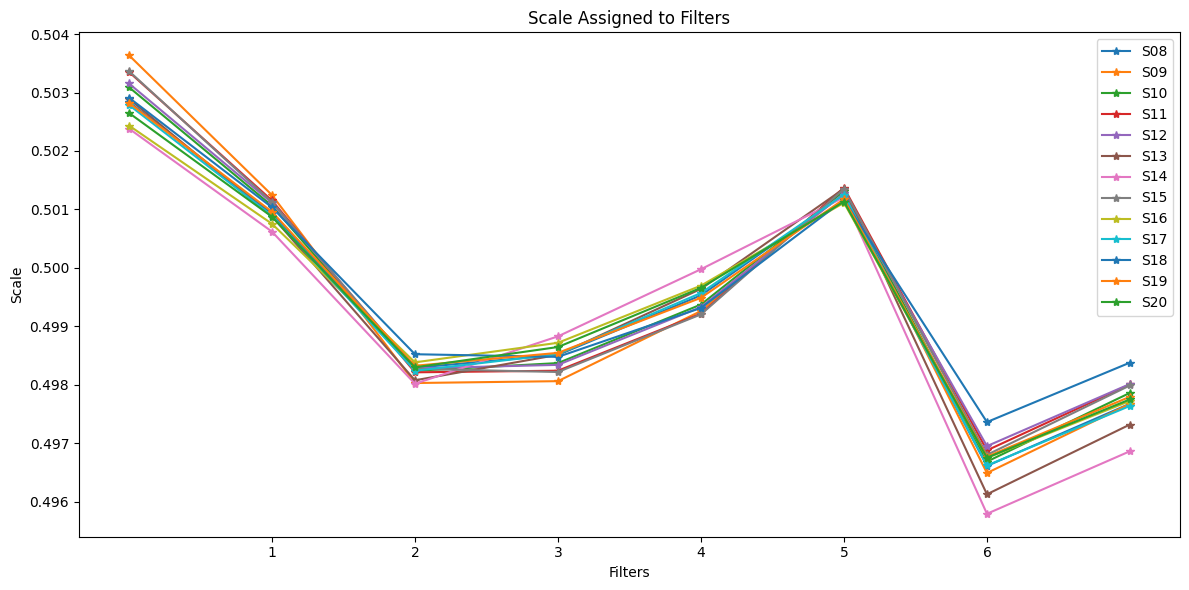

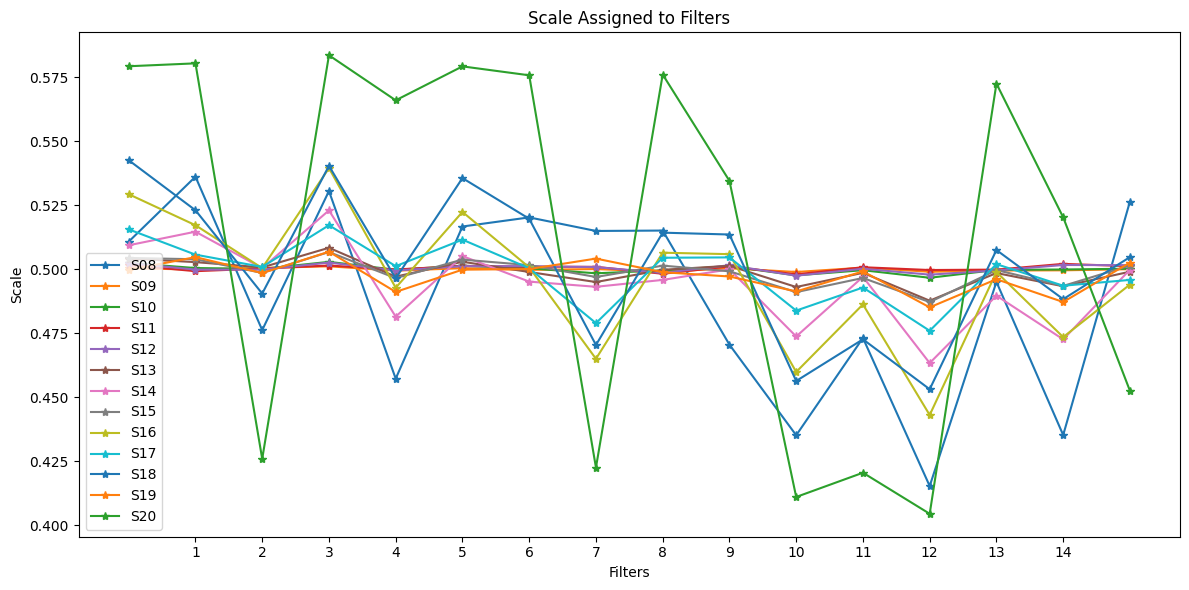

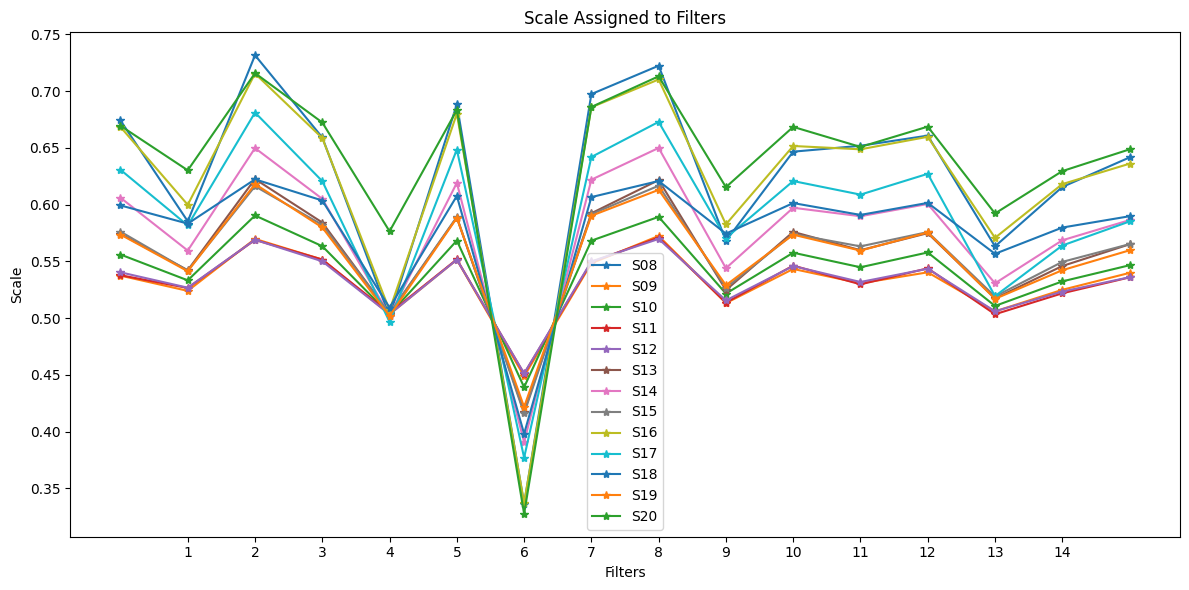

In [ ]:
assigned_ranks = subject_specific_fine_tuning(seLayer=True, denseLayer=True, conv2dLayer=False)
lineplot_for_filterranks(list(assigned_ranks['filter_se1']))
lineplot_for_filterranks(list(assigned_ranks['filter_se2']))
lineplot_for_filterranks(list(assigned_ranks['filter_se3']))

In [12]:
finetuned_rank_layer1, finetuned_rank_layer2 = subject_specific_fine_tuning(seLayer=True, denseLayer=False, conv2dLayer=False)
heatmap_for_electrodes_at_Layer1(finetuned_rank_layer1, 'ElectrodeRanker_FineTuned')
# heatmap_for_electrodes_at_Layer2(el_rank2)

d:\Praveen\PostDoc@SIT\.venv\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\postd\AppData\Local\Temp\ipykernel_20236\3326095628.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting 

SE layer is fine-tuned
Subject: 08, Test Accuracy: 52.08%


d:\Praveen\PostDoc@SIT\.venv\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
C:\Users\postd\AppData\Local\Temp\ipykernel_20236\3326095628.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting 

SE layer is fine-tuned
Subject: 09, Test Accuracy: 58.33%
SE layer is fine-tuned
Subject: 10, Test Accuracy: 45.83%
SE layer is fine-tuned
Subject: 11, Test Accuracy: 52.08%
SE layer is fine-tuned
Subject: 12, Test Accuracy: 50.00%
SE layer is fine-tuned
Subject: 13, Test Accuracy: 68.75%
SE layer is fine-tuned
Subject: 14, Test Accuracy: 64.58%
SE layer is fine-tuned
Subject: 15, Test Accuracy: 50.00%
SE layer is fine-tuned
Subject: 16, Test Accuracy: 50.00%
SE layer is fine-tuned
Subject: 17, Test Accuracy: 66.67%
SE layer is fine-tuned
Subject: 18, Test Accuracy: 58.33%
SE layer is fine-tuned
Subject: 19, Test Accuracy: 62.50%
SE layer is fine-tuned
Subject: 20, Test Accuracy: 68.75%
Average Accuracy: 57.53205128205128
[52.083333333333336, 58.333333333333336, 45.83333333333333, 52.083333333333336, 50.0, 68.75, 64.58333333333334, 50.0, 50.0, 66.66666666666666, 58.333333333333336, 62.5, 68.75]


In [14]:
print(pre_trained_rank_layer1[3])
print(finetuned_rank_layer1[3])

[0.5095514059066772, 0.404610276222229, 0.7832359075546265, 0.2763622999191284, 0.46803784370422363, 0.6825838088989258, 0.6582853198051453, 0.4660084843635559, 0.4718725085258484, 0.5968164205551147, 0.5751463770866394, 0.6172091364860535, 0.5935453772544861, 0.36237120628356934, 0.5953468084335327, 0.544609010219574, 0.744745135307312, 0.5708105564117432, 0.22827956080436707, 0.5246698260307312, 0.5793057680130005, 0.2519969940185547, 0.4421117901802063, 0.4883900582790375, 0.7142292261123657, 0.26491671800613403, 0.6401401162147522]
[0.5339916348457336, 0.41193926334381104, 0.7854952812194824, 0.27606523036956787, 0.46669983863830566, 0.6965579986572266, 0.6750357151031494, 0.46274611353874207, 0.4738900363445282, 0.5973254442214966, 0.5929598212242126, 0.6085380911827087, 0.5778054594993591, 0.3615140914916992, 0.6071254014968872, 0.5497311949729919, 0.7492430210113525, 0.5713920593261719, 0.21955309808254242, 0.5381532907485962, 0.5802817940711975, 0.24604319036006927, 0.430469751